In [22]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn as skl
from tensorflow import keras
from tensorflow.keras import layers

# Load SNP data from CSV file (already transposed, GIDs as row names, SNPs as columns)
def load_snp_csv(snp_file):
        df = pd.read_csv(snp_file, index_col=0)  # GIDs are row indices
        df = df.astype(float)  # Ensure numerical values
        return df

# Load height data from CSV file
def load_yield_data(yield_file):
        yield_df = pd.read_csv(yield_file)
        return yield_df.set_index("GID_filtered")  # Ensure genetic ID is the index
    
print("done 1")

done 1


In [2]:
# Load the data
#X = pd.read_csv("SNPs_phased_reduced.csv")
X = load_snp_csv("SNPs_phased_reduced.csv")
#Y = load_height_data("yield_data_reduced.csv")
#Y = pd.read_csv("yield_data_reduced.csv")

print("done 2")

done 2


In [25]:
Y = load_yield_data("yield_data_reduced1.csv")
print("done 2.5")

done 2.5


In [26]:
# Ensure that we only use samples that have height data
matching_samples = list(set(X.index) & set(Y.index))

# Filter SNP and height data for matching samples
X = X.loc[matching_samples]  # GIDs are already rows
Y = Y.loc[matching_samples, "Y"].values.flatten()

print("done 3")


done 3


In [27]:
len(Y)

18085

In [49]:
# Split and normalise data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("done 4")


done 4


In [50]:

# Build the neural network model
#model = keras.Sequential([
#    layers.Input(shape=(X_train.shape[1],)),
#    layers.Dense(128, activation='relu'),
#    layers.Dropout(0.3),
#    layers.Dense(64, activation='relu'),
#    layers.Dense(1)
#])

model = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(256, activation='relu'),  
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])

# Train the model
history = model.fit(X_train_scaled, Y_train, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
362/362 [==============================] - 24s 64ms/step - loss: 4.5828 - mae: 1.4304 - root_mean_squared_error: 2.1407 - val_loss: 0.6303 - val_mae: 0.6044 - val_root_mean_squared_error: 0.7939
Epoch 2/50
362/362 [==============================] - 22s 60ms/step - loss: 0.9301 - mae: 0.7665 - root_mean_squared_error: 0.9644 - val_loss: 0.4536 - val_mae: 0.5177 - val_root_mean_squared_error: 0.6735
Epoch 3/50
362/362 [==============================] - 22s 60ms/step - loss: 0.7993 - mae: 0.7113 - root_mean_squared_error: 0.8940 - val_loss: 0.4169 - val_mae: 0.5042 - val_root_mean_squared_error: 0.6457
Epoch 4/50
362/362 [==============================] - 21s 59ms/step - loss: 0.7099 - mae: 0.6679 - root_mean_squared_error: 0.8425 - val_loss: 0.4245 - val_mae: 0.5093 - val_root_mean_squared_error: 0.6515
Epoch 5/50
362/362 [==============================] - 22s 61ms/step - loss: 0.6647 - mae: 0.6477 - root_mean_squared_error: 0.8153 - val_loss: 0.3637 - val_mae: 0.4707 - val_ro

In [51]:
# Evaluate the model
test_loss, test_mae, test_rmse = model.evaluate(X_test_scaled, Y_test)
print(f"Test MAE: {test_mae}")

# Make predictions
predictions = model.predict(X_test_scaled)

# Save the model
model.save('wheat_height_predictor.h5')

114/114 [==============================] - 1s 5ms/step - loss: 0.2603 - mae: 0.3877 - root_mean_squared_error: 0.5102
Test MAE: 0.38768792152404785
114/114 [==============================] - 1s 5ms/step


In [52]:
np.corrcoef(Y_test, predictions.T)

array([[1.        , 0.66849342],
       [0.66849342, 1.        ]])

(3617,)

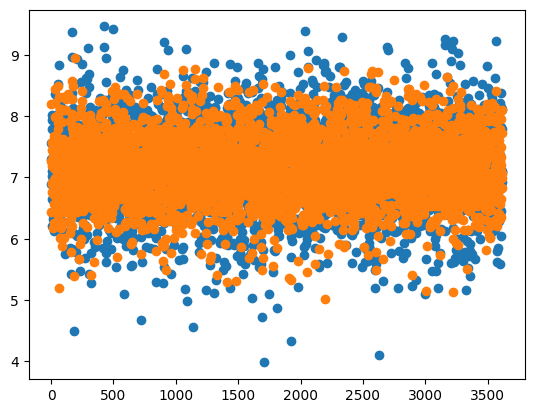

In [59]:
import matplotlib.pyplot as plt
plt.plot(Y_test, 'o')
plt.plot(predictions, 'o')
#Y_test.shape